In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

# Using Univariate Gaussian Distribution:
In the univariate case, input x (or feature) is univariate, meaning x is a scalar rather than a vector. The feature is assumed to follow a univariate Gaussian distribution. The probability density function (PDF) is:

![alt text](../images/univariate.png)

In [ ]:
class BayesianDecisionTheoryUnivariate:
    """
    Bayesian Decision Theory Classifier for univariate data with configurable cost matrix.
    """
    def __init__(self, cost_matrix=None):
        self.prior_probabilities = {}
        self.class_means = {}
        self.class_variances = {}
        self.classes = None

        self.cost_matrix = cost_matrix if cost_matrix is not None else np.array([[0, 10], [50, 0]])

    def fit(self, X, y):
        """
        Fit the model with training data and calculate priors, means, and variances.
        X: NumPy array of shape (n_samples, 1)
        y: NumPy array of shape (n_samples,)
        """
        self.classes = np.unique(y)
        n_samples = len(y)

        for c in self.classes:
            self.prior_probabilities[c] = np.sum(y == c) / n_samples
            class_data = X[y == c]
            self.class_means[c] = np.mean(class_data)
            self.class_variances[c] = np.var(class_data)

    def _calculate_likelihood(self, x, class_label):
        """
        Calculate the likelihood of a data point given a class using the univariate normal distribution.
        """
        mean = self.class_means[class_label]
        variance = self.class_variances[class_label]

        if variance == 0:
            return 0

        exponent = -0.5 * ((x - mean) ** 2) / variance
        normalizer = 1 / np.sqrt(2 * np.pi * variance)
        return normalizer * np.exp(exponent)

    def predict_proba(self, X):
        """
        Predict the posterior probabilities for each class.
        X: NumPy array of shape (n_samples, 1)
        """
        probabilities = []
        for x in X:
            posteriors = {c: self._calculate_likelihood(x, c) * self.prior_probabilities[c] for c in self.classes}
            total_probability = sum(posteriors.values())

            if total_probability > 0:
                for c in posteriors:
                    posteriors[c] /= total_probability

            probabilities.append([posteriors.get(0, 0), posteriors.get(1, 0)])
        return np.array(probabilities)

    def calculate_risk(self, probabilities):
        """
        Calculate the risk for each class based on the cost matrix.
        probabilities: NumPy array of shape (n_samples, n_classes)
        """
        risks = []
        for probs in probabilities:
            risk_0 = probs[0] * self.cost_matrix[0, 0] + probs[1] * self.cost_matrix[0, 1]
            risk_1 = probs[0] * self.cost_matrix[1, 0] + probs[1] * self.cost_matrix[1, 1]
            risks.append([risk_0, risk_1])
        return np.array(risks)

    def predict(self, X):
        """
        Predict class labels by choosing the class with the minimum risk.
        X: NumPy array of shape (n_samples, 1)
        """
        probabilities = self.predict_proba(X)
        risks = self.calculate_risk(probabilities)
        return np.argmin(risks, axis=1)

## EDA

In [4]:
def load_data():
    data = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Cancer.csv')
    return data

In [7]:
data = load_data()

In [8]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [9]:
data = data.drop(columns=['id', 'Unnamed: 32'], axis=1)
data = data.assign(diagnosis=(data['diagnosis'] == 'M').astype(int).values)


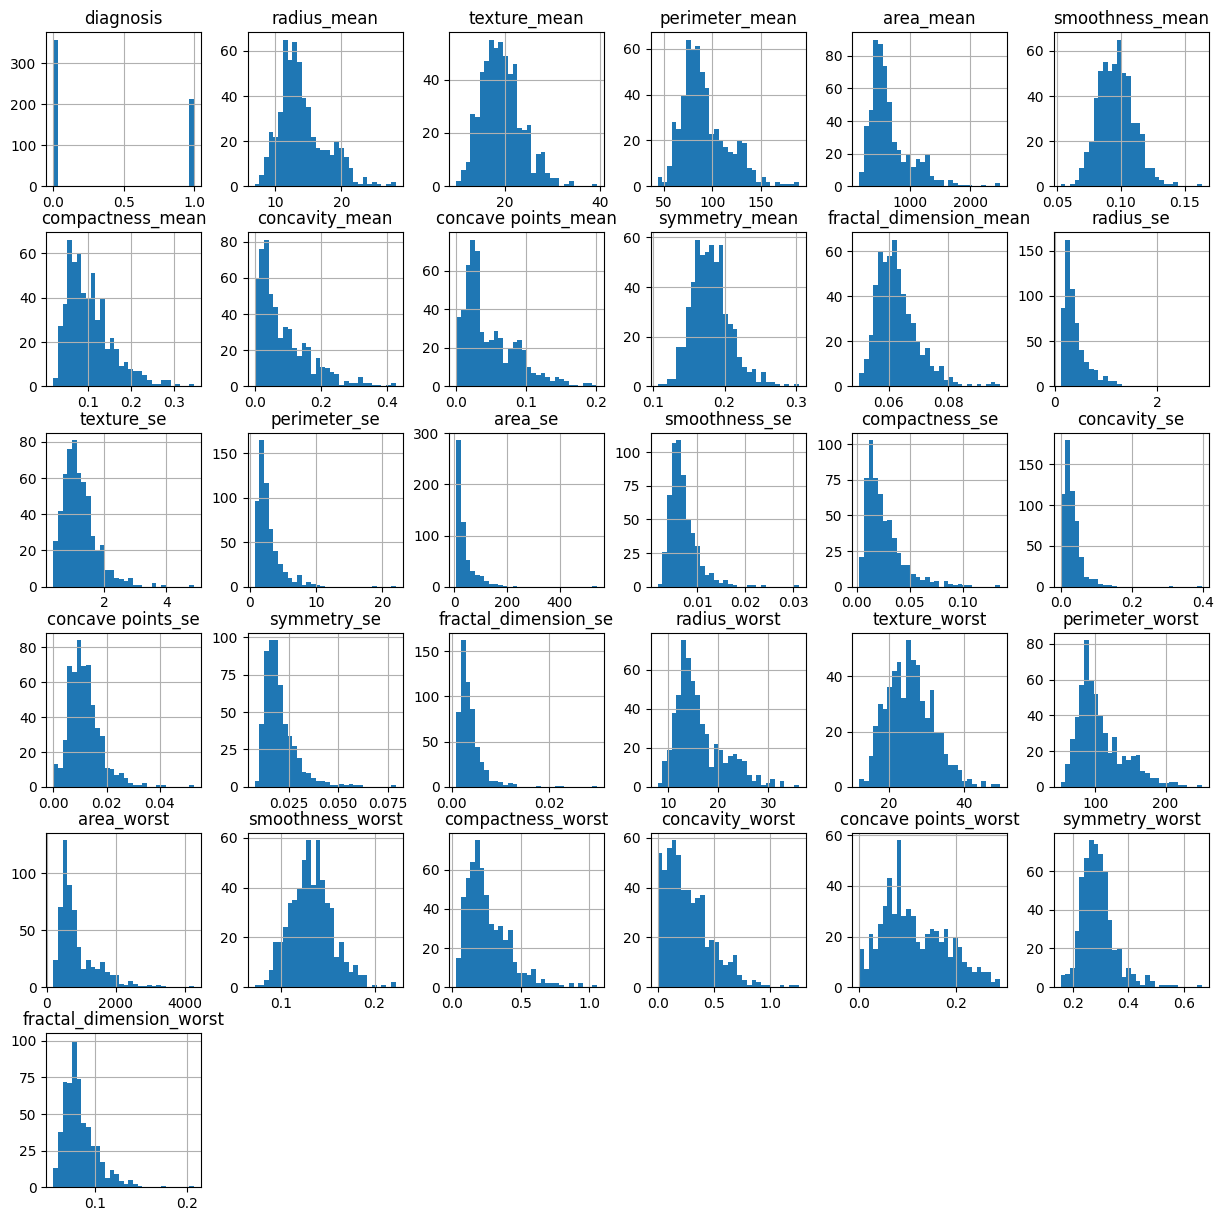

In [10]:
data.hist(figsize=(15, 15), bins=30)
plt.show()

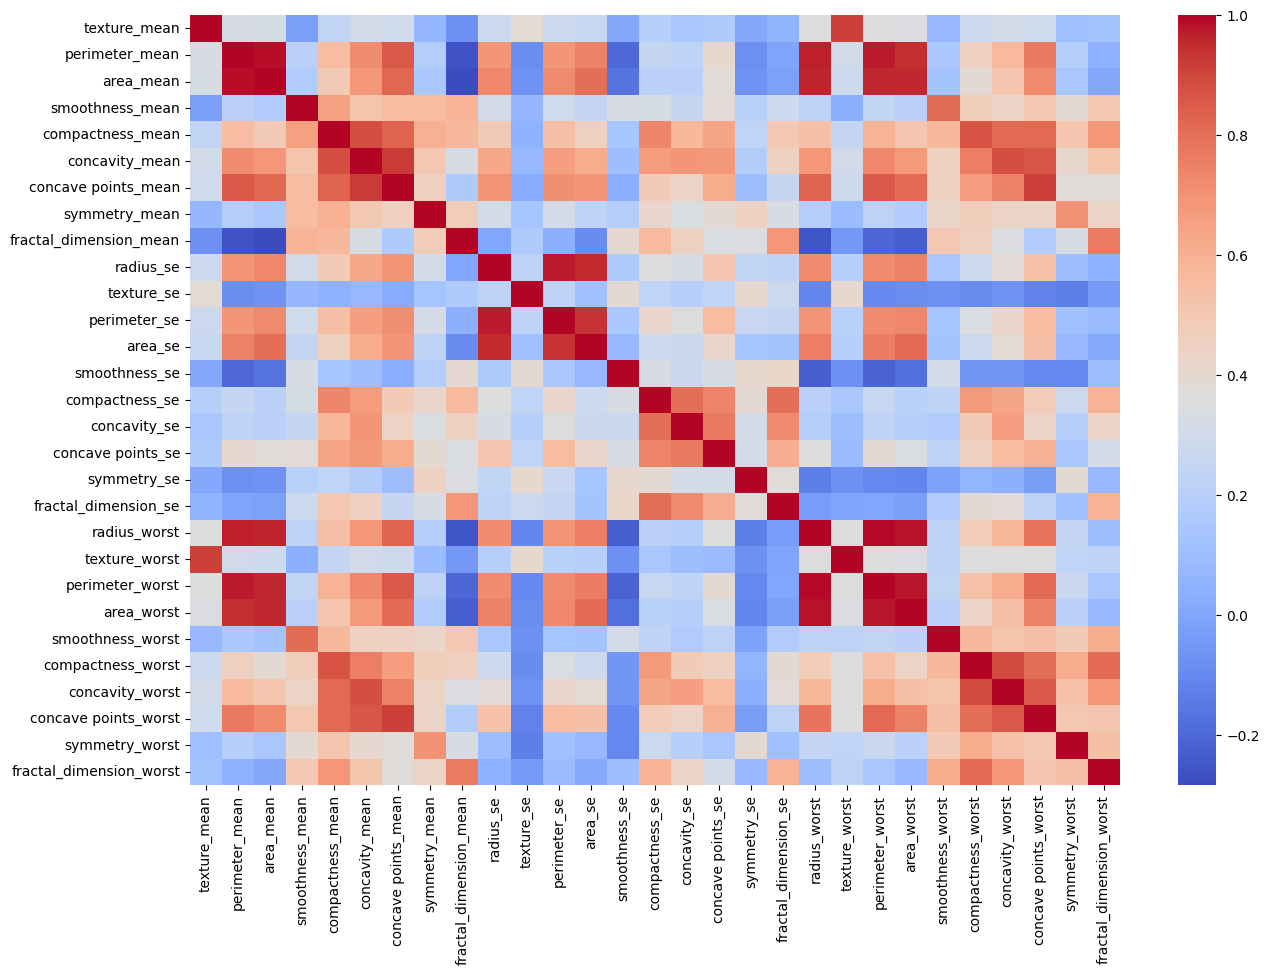

In [ ]:
correlation_matrix = data.iloc[:, 2:].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.show()


## Data Preparation

In [39]:
def prepare_data(data, chosen_features):

    X = data[chosen_features].values
    y = data['diagnosis'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = prepare_data(data, ['radius_mean'])

In [41]:
bdt = BayesianDecisionTheoryUnivariate()
bdt.fit(X_train, y_train)

## Predict and Evaluate model

In [42]:

y_pred = bdt.predict(X_test)
probabilities = bdt.predict_proba(X_test)
risks = bdt.calculate_risk(probabilities)
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(f"Model Accuracy: {accuracy:.2f}")
print(f"Average Risk: {np.mean(risks):.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


Model Accuracy: 0.85
Average Risk: 17.53
MSE: 0.15
RMSE: 0.39


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a confusion matrix using Seaborn.
    :param y_true: Ground truth labels
    :param y_pred: Predicted labels
    """
    print(f"Length mismatch: y_true has {len(y_true)} elements, y_pred has {len(y_pred)} elements.")
    y_pred = y_pred.ravel()
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
    print(cm)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.title('Confusion Matrix')
    plt.show()

Length mismatch: y_true has 114 elements, y_pred has 114 elements.
Predicted   0   1
Actual           
0          71   0
1          17  26


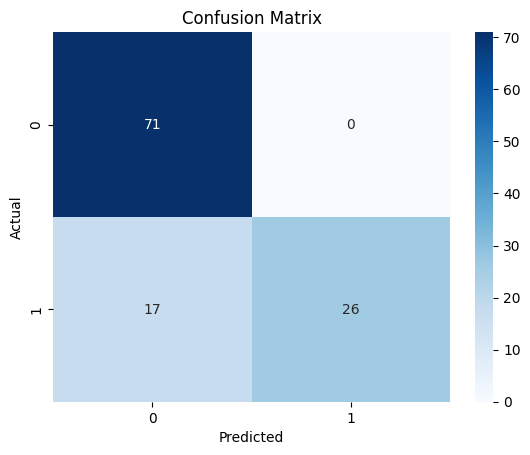

In [43]:
plot_confusion_matrix(y_test, y_pred)

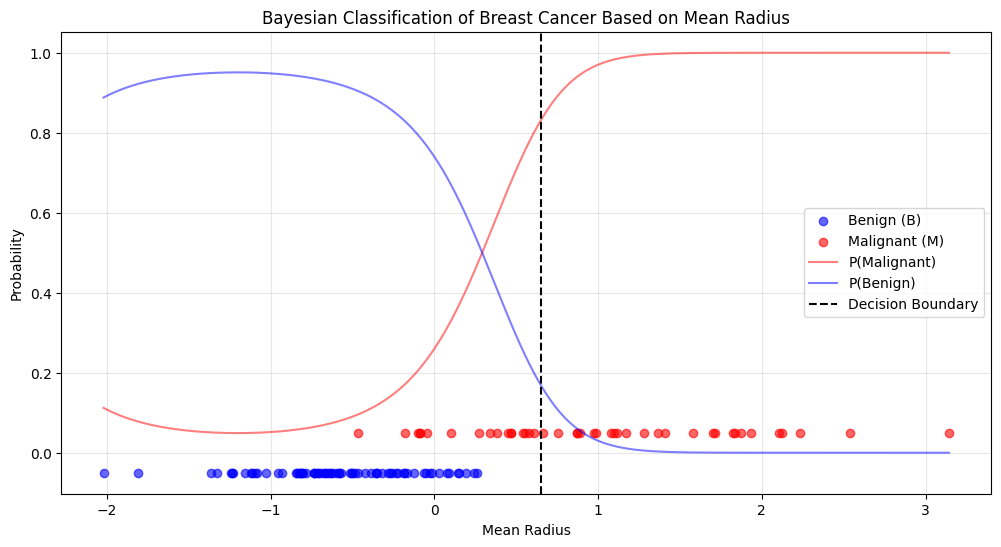

In [50]:
x_range = np.linspace(min(X_test), max(X_test), 1000).reshape(-1, 1)
y_pred = bdt.predict(x_range)
probs = bdt.predict_proba(x_range)

plt.figure(figsize=(12, 6))

plt.scatter(X_test[y_test == 0], np.zeros_like(X_test[y_test == 0]) - 0.05, 
           c='blue', label='Benign (B)', alpha=0.6, marker='o')
plt.scatter(X_test[y_test == 1], np.zeros_like(X_test[y_test == 1]) + 0.05, 
           c='red', label='Malignant (M)', alpha=0.6, marker='o')

plt.plot(x_range, probs[:, 1], 'r-', alpha=0.5, label='P(Malignant)')
plt.plot(x_range, probs[:, 0], 'b-', alpha=0.5, label='P(Benign)')

for i in range(len(x_range)-1):
    if y_pred[i] != y_pred[i+1]:
        plt.axvline(x=x_range[i], color='black', linestyle='--', 
                   label='Decision Boundary')
        break

plt.xlabel('Mean Radius')
plt.ylabel('Probability')
plt.title('Bayesian Classification of Breast Cancer Based on Mean Radius')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
